In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fileI(filename):
    tmp = []
    f = open(filename,'r');
    lines = f.readlines()
    for line in lines:
        tmp.append(line);
    out=np.zeros([len(tmp),5]);
    for i in range(len(out)):
        out[i,:] = np.array(tmp[i].split()).astype(np.float)
    return out;

In [3]:
phi = np.random.uniform(0,2*np.pi)

In [4]:
def tau(m,n,k):
    return  k/(n-m);

In [46]:
def Psi(t,m,n,k):
    out = 0;
    for j in range(m,n):
        out += np.exp(1j*2*np.pi*j*(t-tau(m,n,k)));
    out = out/(n-m);
    return out;

In [47]:
def a(m,n,k,tf,dt):
    N = int(tf/dt);
    out = 0;
    for l in range(N):
        tl = l*dt
        out += Ug(tl/tf)*(dt/tf)*Psi(tl,m,n,k);
    return out;

In [50]:
def f(t,m,n,dt,tf):
    out = 0+0j;
    for k in range(n-m):
        theta = np.angle(a(m,n,k,tf,dt));
        for j in range(m,n):
            phi = np.random.uniform(0,2*np.pi);
            out += (np.abs(a(m,n,k,tf,dt))/(n-m))*np.cos(1j*2*np.pi*j*(t-tau(m,n,k))+theta+phi);
    out *= 2;
    return out;

In [10]:
def Ug(t):
    out = np.interp(t,time,th);
    return out;

In [11]:
data = fileI('RSN454_MORGAN_GIL067.AT2');

C:\Users\OWNER\AppData\Local\Temp/ipykernel_18784/2418606376.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[i,:] = np.array(tmp[i].split()).astype(np.float)


In [12]:
th = np.zeros(len(data)*5);

In [13]:
idx = 0;
for i in range(len(data)):
    for j in range(5):
        th[idx] = data[i,j];
        idx += 1;

In [14]:
dt = 0.005;
N = len(th);
tmax = dt*N;
time = np.arange(0,tmax,dt);

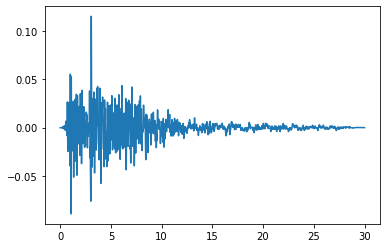

In [15]:
plt.plot(time,th);

In [ ]:
th1 = np.zeros(10);
for i in range(len(th1)):
    th1[i] = f(t=time[i],m=0,n=20,dt=dt,tf=tmax)

C:\Users\OWNER\AppData\Local\Temp/ipykernel_18784/3000306691.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  th1[i] = f(t=time[i],m=0,n=20,dt=dt,tf=tmax)


In [ ]:
plt.plot(th1.real);